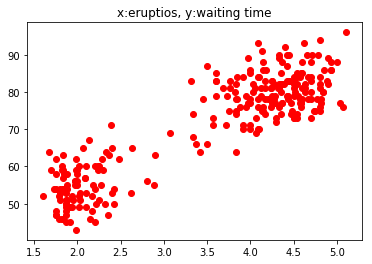

In [930]:
# for question b
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
import math
import random




file = open('./data/geyser.txt', 'r') 
header = file.readline().strip().split()

data = []
for line in file:
    temp = line.strip().split()[1:]
    temp[0] = float(temp[0])
    temp[1] = int(temp[1])
    data.append(temp)
file.close()    


# get data array 
data_array = np.array(data)


# plot all data on 2D plane 
plt.scatter(data_array[:, 0], data_array[:, 1], c='r')
plt.title('x:eruptios, y:waiting time')
plt.savefig('data_on_2D_plane')



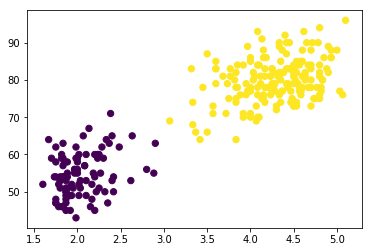

In [931]:
# for question c. Use sklearn GMM 
model = GaussianMixture(n_components = 2, ).fit(data_array)

labels = model.predict(data_array)
plt.scatter(data_array[:, 0], data_array[:, 1], c=labels, s=40, cmap='viridis');



In [932]:
erruption_time = []
waiting_time = []

for line in data_array:
    erruption_time.append(line[0])
    waiting_time.append(line[1])

print(data_array[0:5])

[[ 3.6   79.   ]
 [ 1.8   54.   ]
 [ 3.333 74.   ]
 [ 2.283 62.   ]
 [ 4.533 85.   ]]


In [933]:
## for question c
## define all the functions
def update_assignment(f_data_array, f_u_c1, f_u_c2, f_sigma_c1, f_sigma_c2, f_pi_c1):
    assignment = []
    for line in f_data_array:
        prob_given_c1 = multivariate_normal.pdf(line, mean=f_u_c1, cov=np.diag(f_sigma_c1))
        prob_given_c2 = multivariate_normal.pdf(line, mean=f_u_c2, cov=np.diag(f_sigma_c2))
                
        prob_c1 = (prob_given_c1 * f_pi_c1)/(prob_given_c1 * f_pi_c1 + prob_given_c2 * (1-f_pi_c1))
        
        #print(line, f_u_c1, f_sigma_c1)
        #print(prob_given_c1)
        #print(line, f_u_c2, f_sigma_c2)
        #print(prob_given_c2)
        #print(prob_c1)
        
        assignment.append(prob_c1)
    return assignment

# get mean vector, given assignment
# f_assignment is the probability of component 1
def update_mean(f_data_array, f_assignment):
    tmp_array = f_data_array.copy()    
    for i in range(len(f_data_array)):
        tmp_array[i] = f_data_array[i] * f_assignment[i]        
    tmp0 = np.sum(tmp_array[:,0])/np.sum(f_assignment)
    tmp1 = np.sum(tmp_array[:,1])/np.sum(f_assignment)    
    return np.array([tmp0,tmp1])


## update sigma 
def update_sigma (f_assignment, f_u):
    tmp_sum_e = 0
    tmp_sum_w = 0
    
    sigma_e = 0
    sigma_w = 0
    
    for i in range(len(erruption_time)):
        weighted_element_e =( (erruption_time[i] - f_u[0])**2 ) * f_assignment[i]
        tmp_sum_e += weighted_element_e
        
        weighted_element_w =( (waiting_time[i] - f_u[1])**2 ) * f_assignment[i]
        tmp_sum_w += weighted_element_w
    
    sigma_e = math.sqrt(tmp_sum_e/np.sum(f_assignment)) 
    sigma_w = tmp_sum_w/np.sum(f_assignment)
    
    return [sigma_e,sigma_w]

## update pi
def update_pi_c1 (f_assignment):
    return np.sum(f_assignment)/len(f_assignment)



def EM (f_data_array, f_iter_u_c1, f_iter_u_c2, f_iter_sigma_c1, f_iter_sigma_c2, f_iter_pi_c1, f_threshold, f_iteration_limit):
    em_iteration_number = 0
    em_assignment = []
    em_u_c1 = []
    em_u_c2 = []
    
    #em_u_c1.append(f_iter_u_c1)
    #em_u_c2.append(f_iter_u_c2)
    
    for i in range(f_iteration_limit):
        # soft assignment
        f_iter_assignment = []
        pre_iter_u_c1 = f_iter_u_c1.copy()
        pre_iter_u_c2 = f_iter_u_c2.copy()
        
        f_iter_assignment = update_assignment(f_data_array, f_iter_u_c1, f_iter_u_c2, f_iter_sigma_c1, f_iter_sigma_c2, f_iter_pi_c1)
       
        em_assignment.append(iter_assignment)
        
        f_iter_u_c1 = update_mean(f_data_array, f_iter_assignment)
        em_u_c1.append(f_iter_u_c1)
    
        f_iter_u_c2 = update_mean(f_data_array, np.array(1)-f_iter_assignment)
        em_u_c2.append(f_iter_u_c2)
    
        f_iter_sigma_c1 = update_sigma(f_iter_assignment, f_iter_u_c1)
        f_iter_sigma_c2 = update_sigma(np.array(1)-f_iter_assignment, f_iter_u_c2)
    
        f_iter_pi_c1 = update_pi_c1(f_iter_assignment)
        
        em_iteration_number += 1
        #print(f_iter_u_c2[0],pre_iter_u_c2[0])
        
        
        # calculate the gain of each iteration, if gain < threshold, break 
        gain_c1 = np.linalg.norm( np.array(f_iter_u_c1) - np.array(pre_iter_u_c1) )
        gain_c2 = np.linalg.norm( np.array(f_iter_u_c1) - np.array(pre_iter_u_c1) )        
        if ( gain_c1 < f_threshold ) and ( gain_c2 < f_threshold):
            break
                                
    return em_iteration_number,em_assignment, em_u_c1, em_u_c2

    
# mean vectors
iter_u_c1 = [3,50]
iter_u_c2 = [3.5,60]

# sigma
sigma = [np.std(data_array[:,0]),np.std(data_array[:,1])]
iter_sigma_c1 = sigma
iter_sigma_c2 = sigma

# pi, 
iter_pi_c1 = 0.4

## store the data 
iteration_number,assignment,u_c1,u_c2 = EM(data_array,iter_u_c1,iter_u_c2,iter_sigma_c1,iter_sigma_c2,iter_pi_c1, 0.0001, 100)

print(u_c1)

[array([ 1.98762875, 50.56176027]), array([ 1.99030445, 52.2963395 ]), array([ 2.01020755, 53.63881689]), array([ 2.03236163, 54.27736714]), array([ 2.04241158, 54.45841295]), array([ 2.04707447, 54.52157526]), array([ 2.04919445, 54.54579958]), array([ 2.05013543, 54.55582101]), array([ 2.0505496 , 54.56011724]), array([ 2.05073148, 54.56198552]), array([ 2.05081131, 54.5628025 ]), array([ 2.05084635, 54.56316055]), array([ 2.05086173, 54.56331762]), array([ 2.05086848, 54.56338654])]


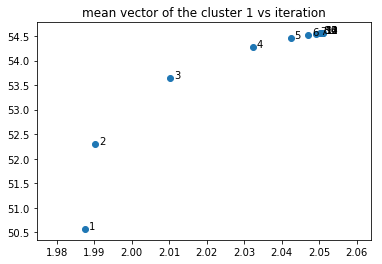

In [934]:
# for question c: plot the trajectory of two mean vectors 
# 
array_u_c1 = np.array(u_c1)
array_u_c2 = np.array(u_c2)
 

plt.scatter(array_u_c1[:,0], array_u_c1[:,1]);
for i in range(len(array_u_c1)):
    plt.annotate(str(i+1), (array_u_c1[i,0]+0.001, array_u_c1[i,1]))

plt.title('mean vector of the cluster 1 vs iteration')
plt.savefig('mean_vector_c1')


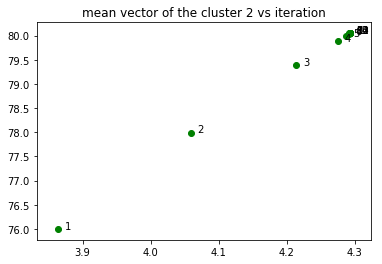

In [935]:
plt.scatter(array_u_c2[:,0], array_u_c2[:,1], c='g');

for i in range(len(array_u_c2)):
    plt.annotate(str(i+1), (array_u_c2[i,0]+0.01, array_u_c2[i,1]))


plt.title('mean vector of the cluster 2 vs iteration')
plt.savefig('mean_vector_c2')

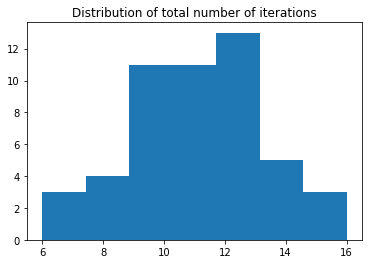

In [936]:
# mean vectors

iteration_number_random = []

for i in range(50):    
    col1 = data_array[:,0]
    col2 = data_array[:,1]
    iter_u_c1 = [random.uniform(min(col1),max(col1)), random.uniform(min(col2),max(col2))]
    iter_u_c2 = [random.uniform(min(col1),max(col1)), random.uniform(min(col2),max(col2))]

    # sigma
    sigma = [np.std(data_array[:,0]),np.std(data_array[:,1])]
    iter_sigma_c1 = [x + random.uniform(1, 10) for x in sigma]
    iter_sigma_c2 = [x + random.uniform(1, 10) for x in sigma]

    # pi, 
    iter_pi_c1 = random.uniform(0,1)

    iteration_number,assignment,u_c1,u_c2 = EM(data_array,iter_u_c1,iter_u_c2,iter_sigma_c1,iter_sigma_c2,iter_pi_c1, 0.001, 100)
    iteration_number_random.append(iteration_number)


plt.hist(iteration_number_random, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of total number of iterations")
plt.savefig('Histogram_iteration_number')


    

[[ 4.29793023 80.28488372]
 [ 2.09433    54.75      ]]
[0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1
 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 1 0]
[ 3.6 79. ]


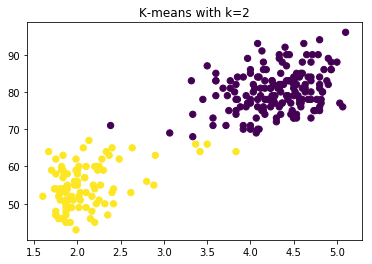

In [940]:
## for question d
kmeans = KMeans(n_clusters=2).fit(data_array)
labels = kmeans.predict(data_array)
plt.scatter(data_array[:, 0], data_array[:, 1], c=labels, s=40, cmap='viridis');
plt.title('K-means with k=2')
plt.savefig('k_means')
c_center = kmeans.cluster_centers_
print(c_center)

print(labels)
print(data_array[0])

In [938]:
# Use the result of KMeans as the first guess
# mean vectors
iter_u_c1 = c_center[0]
iter_u_c2 = c_center[1]

# sigma
#sigma = [np.std(data_array[:,0]),np.std(data_array[:,1])]
iter_sigma_c1 = update_sigma (labels, c_center[0])
iter_sigma_c2 = update_sigma (labels, c_center[1])

# pi, 
iter_pi_c1 = np.sum(labels)/len(labels)

## store the data 
iteration_number,assignment,u_c1,u_c2 = EM(data_array,iter_u_c1,iter_u_c2,iter_sigma_c1,iter_sigma_c2,iter_pi_c1, 0.0001, 100)

print(iteration_number)

10
